#To download the dataset from the drive location, please this following commands

!pip install gdown

import gdown

# Shared folder link
folder_url = 'https://drive.google.com/drive/folders/157YcTuqNeYUu18k_4MnKcPPgcBAIsqtO?usp=drive_link'

# Download the folder
gdown.download_folder(folder_url, output='dataset_folder', quiet=False, use_cookies=False)


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data directories
base_dir = '/content/drive/MyDrive/ISIC_image_data'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32

In [ ]:
def apply_clahe(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

In [ ]:
def polynomial_transform(image):
    return np.clip(np.power(image / 255.0, 2.0) * 255.0, 0, 255).astype(np.uint8)

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)
    image = apply_clahe(image)
    image = polynomial_transform(image)
    return image

In [ ]:
def preprocessing_function(img):
    img = (img * 255).astype(np.uint8)
    img = apply_clahe(img)
    img = polynomial_transform(img)
    return img / 255.0

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
val_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
class_indices = train_gen.class_indices

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.


In [ ]:
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_model()
model.fit(train_gen, epochs=7, validation_data=val_gen)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 763s 9s/step - accuracy: 0.4876 - loss: 0.7492 - val_accuracy: 0.4895 - val_loss: 0.6903
Epoch 2/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 969ms/step - accuracy: 0.5345 - loss: 0.6885 - val_accuracy: 0.4895 - val_loss: 0.6887
Epoch 3/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 964ms/step - accuracy: 0.5383 - loss: 0.6824 - val_accuracy: 0.4895 - val_loss: 0.7025
Epoch 4/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 943ms/step - accuracy: 0.5299 - loss: 0.6840 - val_accuracy: 0.6401 - val_loss: 0.6712
Epoch 5/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 85s 976ms/step - accuracy: 0.5531 - loss: 0.6758 - val_accuracy: 0.6401 - val_loss: 0.6694
Epoch 6/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5693 - loss: 0.6754 - val_accuracy: 0.5045 - val_loss: 0.6730
Epoch 7/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 929ms/step - accuracy: 0.5409 - loss: 0.6741 - val_accuracy: 0.6491 - val_loss: 0.6633


In [ ]:
# Evaluation
y_pred = model.predict(val_gen, steps=len(val_gen))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-score   support

      Benign       0.51      0.42      0.46       339
   Malignant       0.49      0.58      0.53       325

    accuracy                           0.50       664
   macro avg       0.50      0.50      0.50       664
weighted avg       0.50      0.50      0.50       664



In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_curve, auc

In [ ]:
acc = accuracy_score(y_true, y_pred_classes)
print(f"\nValidation Accuracy: {acc:.4f}")


Validation Accuracy: 0.4985


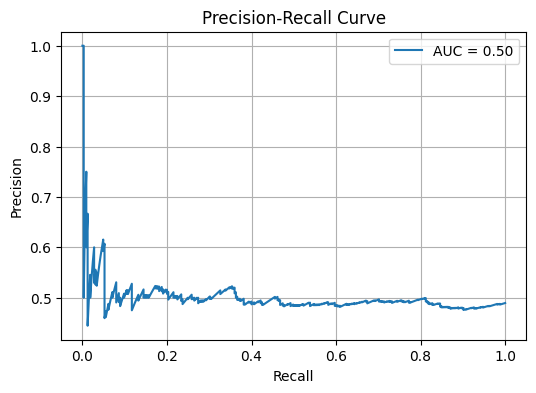

In [ ]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Single image prediction
uploaded = files.upload()
for img_path in uploaded.keys():
    image = preprocess_image(img_path)
    image_input = np.expand_dims(image, axis=0) / 255.0
    prediction = model.predict(image_input)
    pred_class = list(class_indices.keys())[np.argmax(prediction)]
    print(f"Image '{img_path}' predicted as: {pred_class}")